In [6]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import Data_for_bp as dfb

In [ ]:
df = pd.read_pickle('Data for Practicum 2/ticks_2019.pkl')

In [ ]:
time_deltas = df.index.to_series().diff()

In [ ]:
def tick_data_describe(df):
    time_deltas = df.index.to_series().diff()
    summary_data = {
        'Description': [
            'Number of ticks',
            'Mean time between ticks',
            'Median time between ticks',
            'Max time between ticks',
            'Min time between ticks',
            'Ticks with time delta > 10 minutes',
            'Ticks with time delta > 60 seconds',
            'Ticks with time delta > 1 second',
            'Ticks with time delta > 0.1 seconds',
            'Ticks with time delta < 0.1 seconds'
        ],
        'Value': [
            len(df),
            time_deltas.mean(),
            time_deltas.median(),
            time_deltas.max(),
            time_deltas.min(),
            len(time_deltas[time_deltas > pd.Timedelta(minutes=10)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=60)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=1)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=0.1)]),
            len(time_deltas[time_deltas < pd.Timedelta(seconds=0.1)])
        ]
    }

    summary_df = pd.DataFrame(summary_data)
    fig, ax = plt.subplots(figsize=(10, 3))  # set the size
    ax.axis('off')
    ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc = 'center',loc='center')
    plt.show()


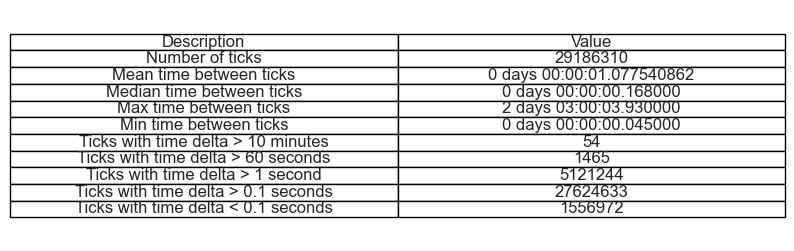

In [ ]:
tick_data_describe(df)

In [ ]:
ohlc = dfb.tick_to_ohlc(df, '1D')

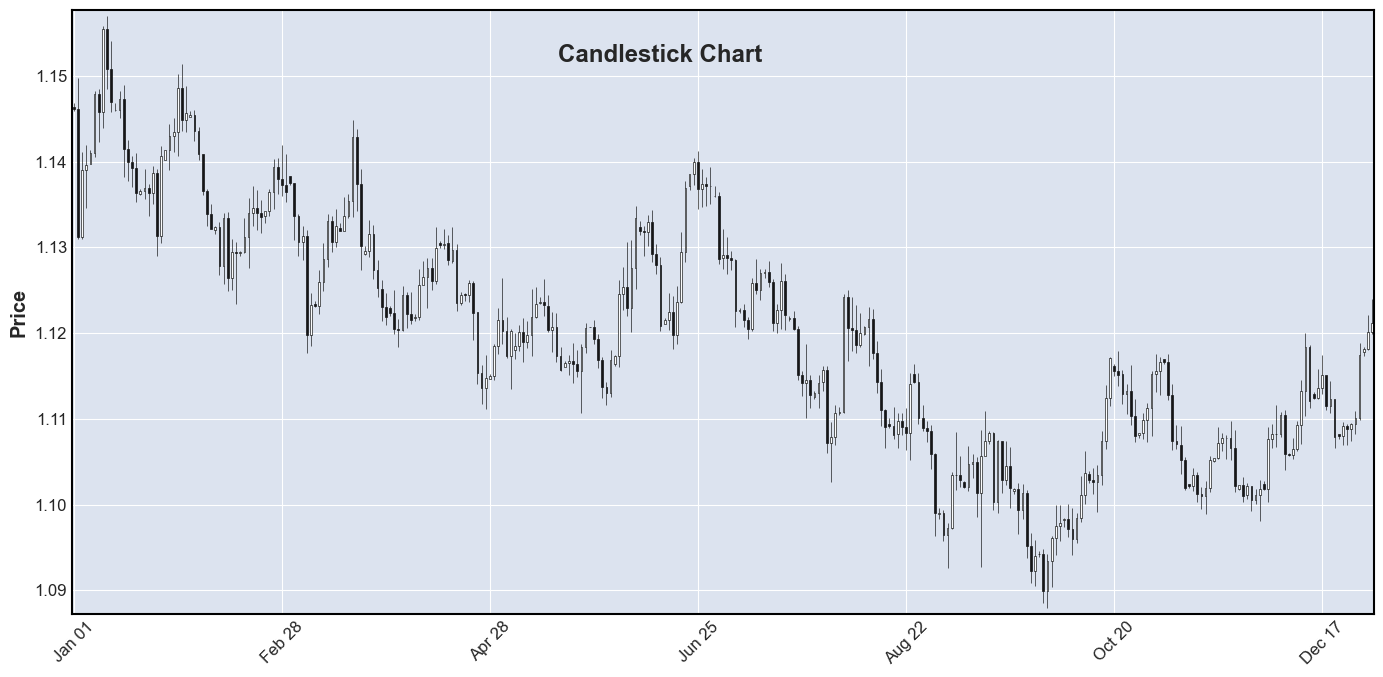

In [ ]:
dfb.plot_data(ohlc)

In [ ]:
def ohlc_stats(ohlc):
    ohlc['returns'] = ohlc['close'].pct_change()
    ohlc['daily_returns'] = (ohlc['close']-ohlc['open'])/ohlc['open']
    daily_volatility = ohlc['returns'].std()
    buy_and_hold_return = (ohlc['returns']+1).prod()
    mean_return = ohlc['returns'].mean()
    

In [ ]:
def ohlc_stats(ohlc):
    ohlc['returns'] = ohlc['close'].pct_change()
    ohlc['daily_returns'] = (ohlc['close']-ohlc['open'])/ohlc['open']
    fig,axs = plt.subplots(3,1,figsize=(10,10))
    axs[0].plot(ohlc['returns'])
    axs[1].hist(ohlc['returns'],bins=20)

    daily_volatility = ohlc['returns'].std()*np.sqrt(252)*100
    buy_and_hold_return = ((ohlc['returns']+1).prod() - 1)*100  # Adjusting to get the total return
    mean_return = ohlc['returns'].mean()*100

    stats_data = {
        'Description': [
            'Daily Volatility',
            'Buy and Hold Return',
            'Mean Return'
        ],
        'Value': [
            daily_volatility,
            buy_and_hold_return,
            mean_return
        ]
    }
    
    stats_df = pd.DataFrame(stats_data)
    axs[2].axis('off')
    axs[2].table(cellText=stats_df.values, colLabels=stats_df.columns, cellLoc = 'center',loc='center')
    fig.tight_layout()
    plt.show()


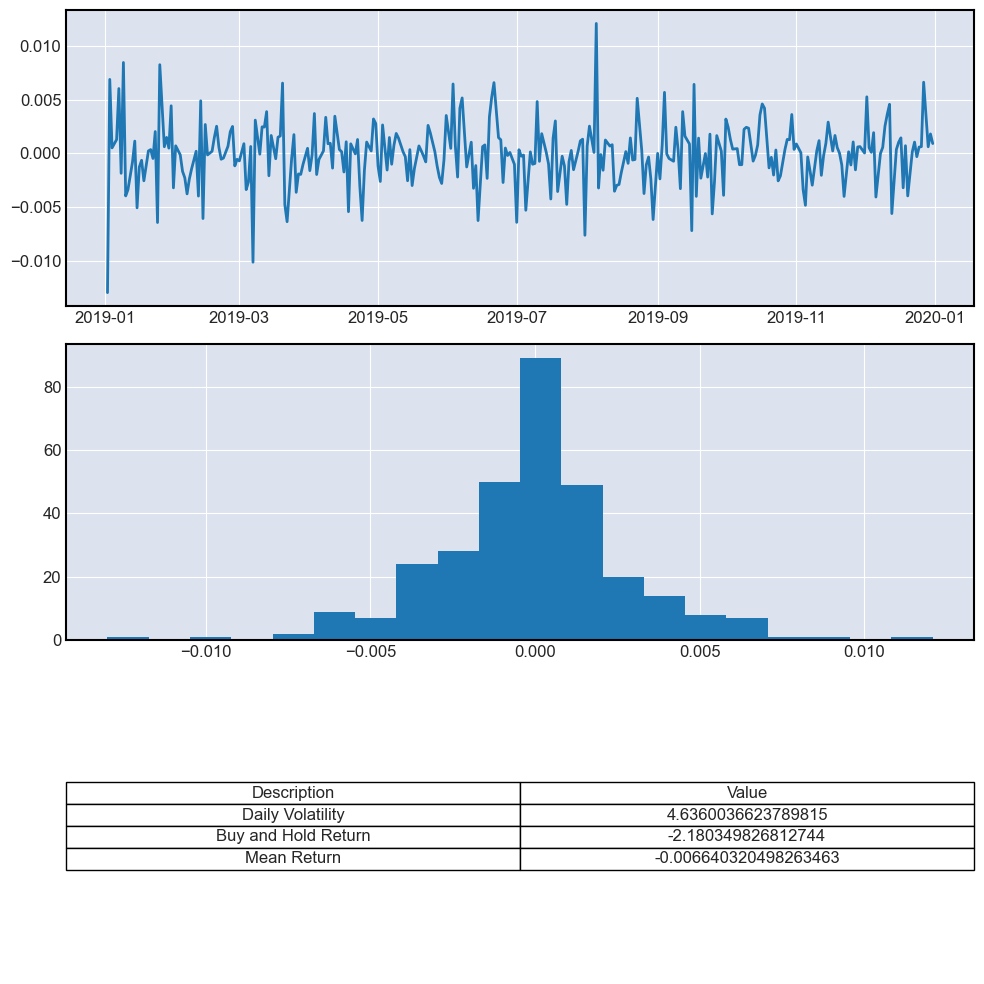

In [ ]:
ohlc_stats(ohlc)

In [ ]:
def data_analysis_for_bp(tick_data_file):
    df = pd.read_pickle(tick_data_file)
    tick_data_describe(df)
    ohlc = dfb.tick_to_ohlc(df, '1D')
    dfb.plot_data(ohlc)
    ohlc_stats(ohlc)

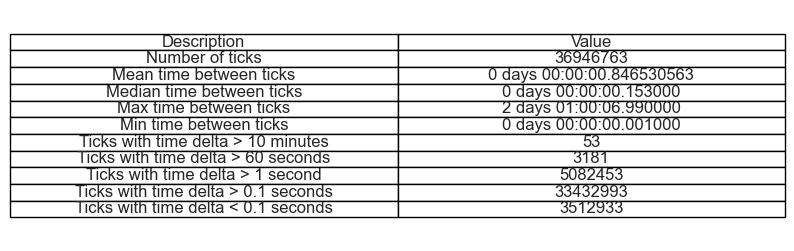

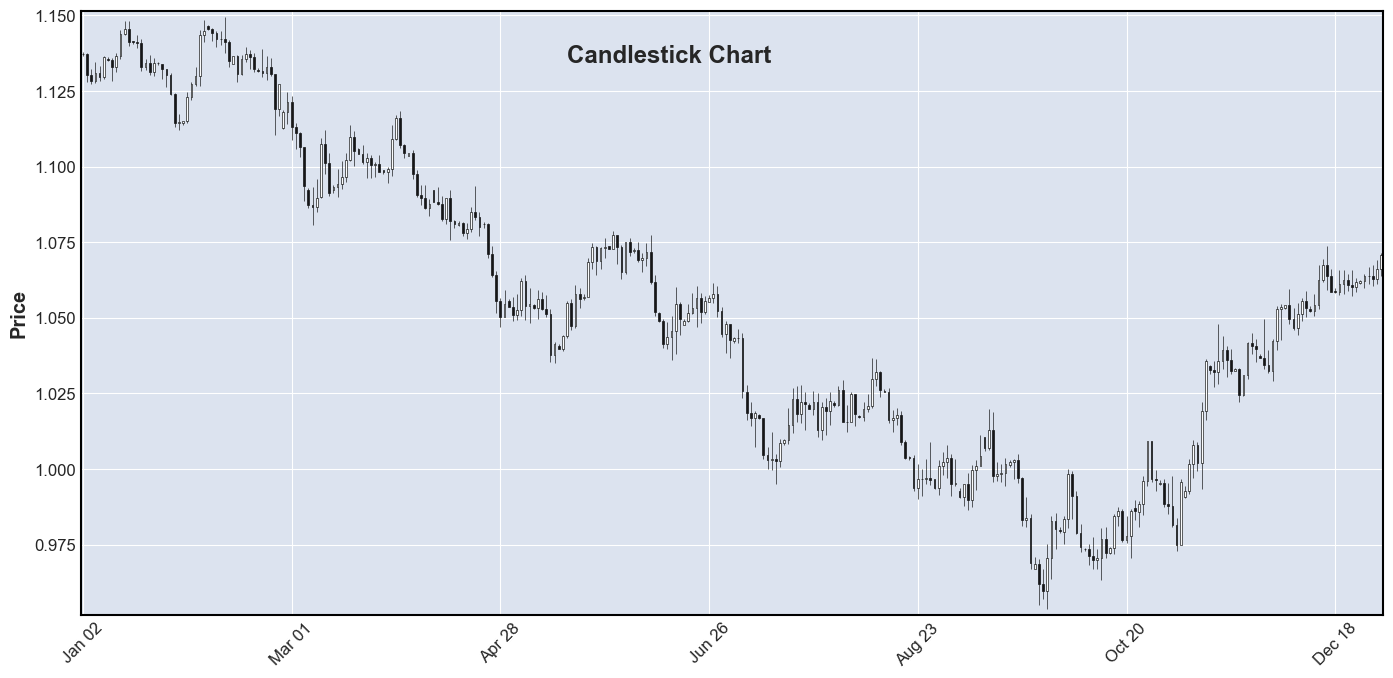

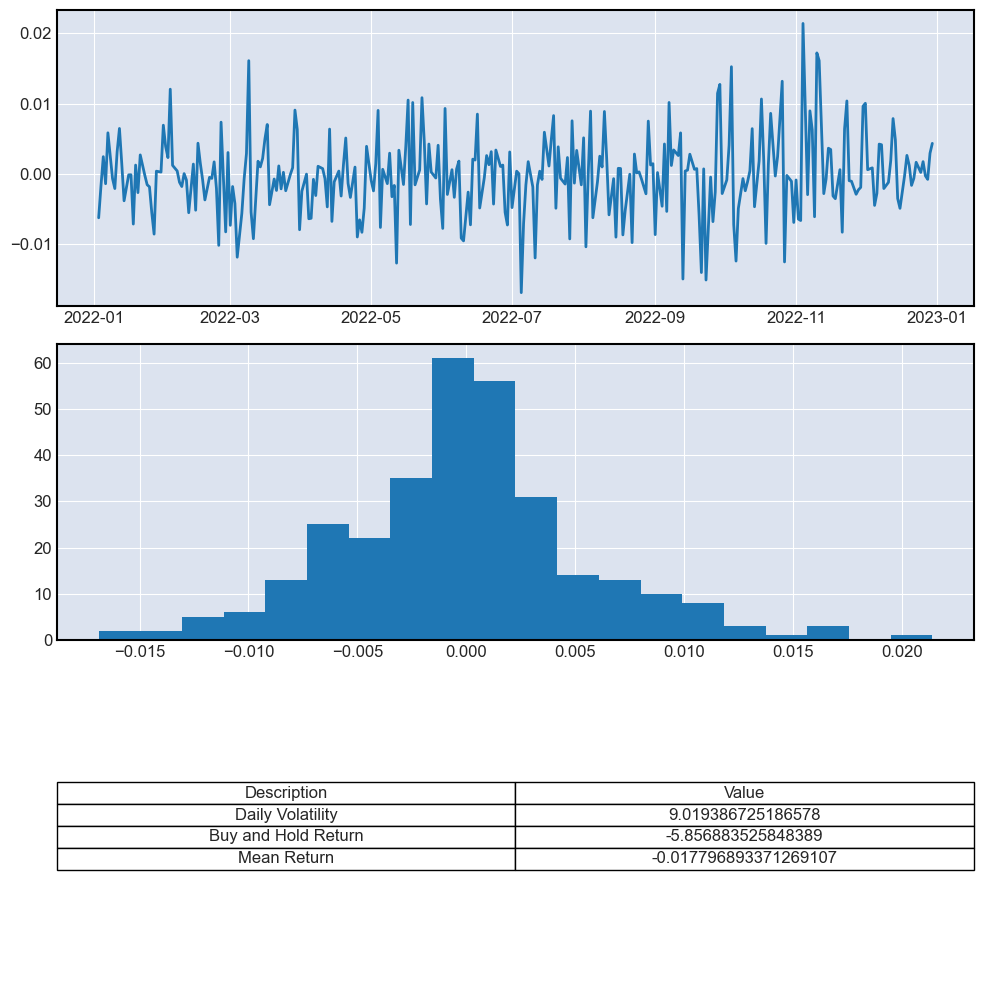

In [ ]:
data_analysis_for_bp('Data for Practicum 2/ticks_2022.pkl')

## Ladder strategy data engineering and strategy visualisation

In [92]:
def ladderize_open(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    ladderized_data = [tick_data.iloc[0]]
    for i in range(1, len(tick_data)):
        if tick_data.iloc[i] > ladderized_data[-1] + grid_size:
            ladderized_data.append(ladderized_data[-1] + grid_size)
        elif tick_data.iloc[i] < ladderized_data[-1] - grid_size:
            ladderized_data.append(ladderized_data[-1] - grid_size)
        else:
            ladderized_data.append(ladderized_data[-1])
    # Adding the final close price
    ladderized_data[-1]=tick_data.iloc[-1]
    return pd.Series(ladderized_data, index=tick_data.index)

In [93]:
def ladderize_absolute(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    # Initialize ladder at the nearest rounded price level based on grid size
    ladderized_data = [(tick_data.iloc[0] / grid_size).round() * grid_size]
    for i in range(1, len(tick_data)):
        if tick_data.iloc[i] > ladderized_data[-1] + grid_size:
            ladderized_data.append(ladderized_data[-1] + grid_size)
        elif tick_data.iloc[i] < ladderized_data[-1] - grid_size:
            ladderized_data.append(ladderized_data[-1] - grid_size)
        else:
            ladderized_data.append(ladderized_data[-1])
    # Adding the final close price
    ladderized_data[-1]=tick_data.iloc[-1]
    return pd.Series(ladderized_data, index=tick_data.index)

In [94]:
def plot_colored_ladder(ladderized_data):
    for i in range(1, len(ladderized_data)):
        if ladderized_data[i] > ladderized_data[i-1]:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='red')
        elif ladderized_data[i] < ladderized_data[i-1]:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='green')
        else:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='blue')  # Neutral color for no change

In [95]:

def plot_ladderized(start_date, end_date, grid_size=0.0005, ladderize_function=ladderize_open):
    # Load the tick data
    tick_data = dfb.get_tick_data(start_date,end_date)['EURUSD.mid']

    ladderized_data = ladderize_function(tick_data, grid_size)

    # Plot the results
    plt.figure(figsize=(15,6))
    plt.plot(tick_data, label='Tick Data',alpha=0.5)
    plot_colored_ladder(ladderized_data)
    # plt.plot(ladderized_data, label='Ladderized Data', linestyle='--')
    plt.title('Ladder Strategy Visualization for date range: {} to {}'.format(start_date, end_date))
    plt.legend()
    plt.show()



2023-09-10 10:29:31,785 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-09-10 10:29:31,786 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD
2023-09-10 10:29:31,787 - findatapy.market.datavendorweb - INFO - Downloading... 2023-08-21 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2023/07/21/00h_ticks.bi5


2023-09-10 10:29:37,107 - findatapy.market.datavendorweb - INFO - Completed request from Dukascopy
2023-09-10 10:29:37,112 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_858__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_... to Redis: Error 61 connecting to 127.0.0.1:6379. Connection refused.


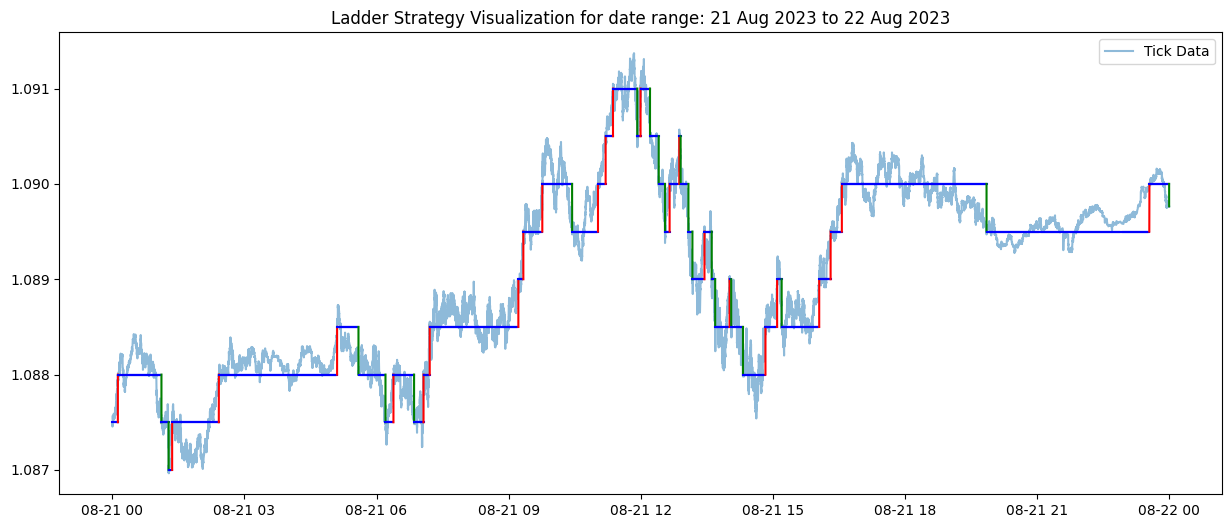

In [96]:
plot_ladderized('21 Aug 2023','22 Aug 2023',grid_size=0.0005,ladderize_function=ladderize_absolute)

In [97]:
tick_data = dfb.get_tick_data('21 Aug 2023','22 Aug 2023')['EURUSD.mid']
ladderized_data = ladderize_absolute(tick_data, grid_size=0.0005)

2023-09-10 10:30:35,019 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2023-09-10 10:30:35,019 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURUSD


2023-09-10 10:30:35,022 - findatapy.market.datavendorweb - INFO - Downloading... 2023-08-21 00:00:00 https://www.dukascopy.com/datafeed/EURUSD/2023/07/21/00h_ticks.bi5
2023-09-10 10:30:40,342 - findatapy.market.datavendorweb - INFO - Completed request from Dukascopy
2023-09-10 10:30:40,349 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_858__abstract_curve_key-None__base_depos_currencies-EUR_GBP_AUD_NZD_USD_CAD_CHF_NOK_SEK_JPY__base_depos_tenor-ON_TN_SN_1W_2W_3W_1M_... to Redis: Error 61 connecting to 127.0.0.1:6379. Connection refused.


In [103]:
def filter_jumps(ladderized_data):
    """
    Filters ladderized data to keep only the changes in price.

    :param ladderized_data: A pandas Series of ladderized data.
    :return: A pandas Series containing only the data points where there's a change.
    """
    # Calculate the difference between consecutive ladderized data points
    diff = ladderized_data.diff()

    # Filter where the difference is non-zero and include the first data point
    jumps = ladderized_data[diff != 0.0]
    jumps = pd.concat([ladderized_data.iloc[:1], jumps])

    return jumps


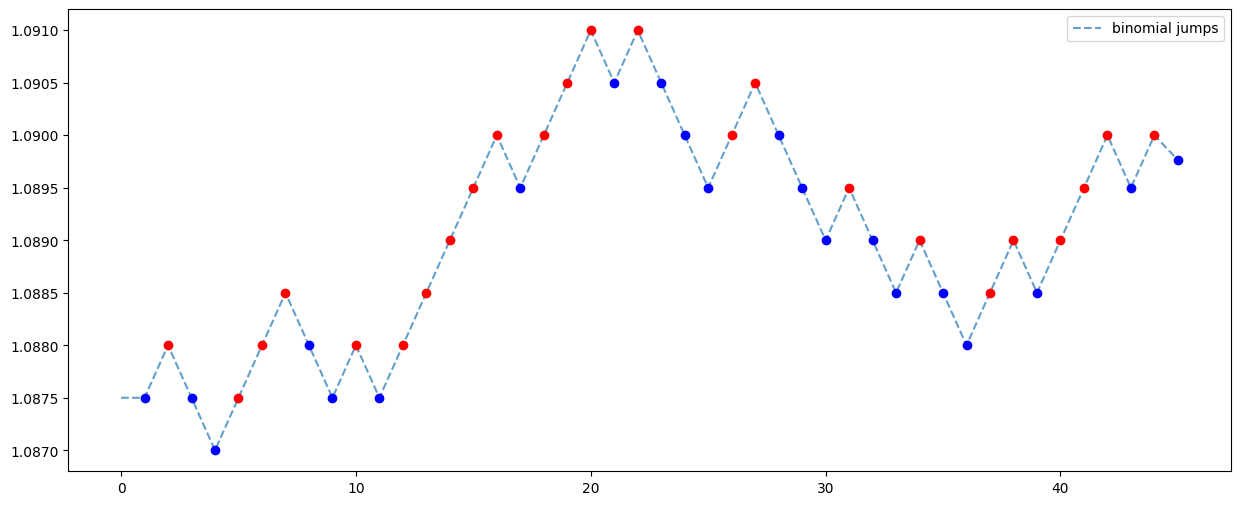

In [107]:
jumps = filter_jumps(ladderized_data)
plt.figure(figsize=(15,6))
# Plotting the jumps
plt.plot(jumps.values, label='binomial jumps', linestyle='--', alpha=0.7)
# Adding colored points for up and down movements
previous_value = jumps.values[0]
for idx, value in enumerate(jumps.values[1:], 1):
    if value > previous_value:
        plt.plot(idx, value, 'ro')  # Red point for upward movement
    else:
        plt.plot(idx, value, 'bo')  # Blue point for downward movement
    previous_value = value

plt.legend()
plt.show()

In [108]:
def velocity(data):
    return data.diff()/data

def acceleration(data):
    return data.diff().diff()/data

In [119]:
jump_ema = jumps.ewm(span=3).mean()

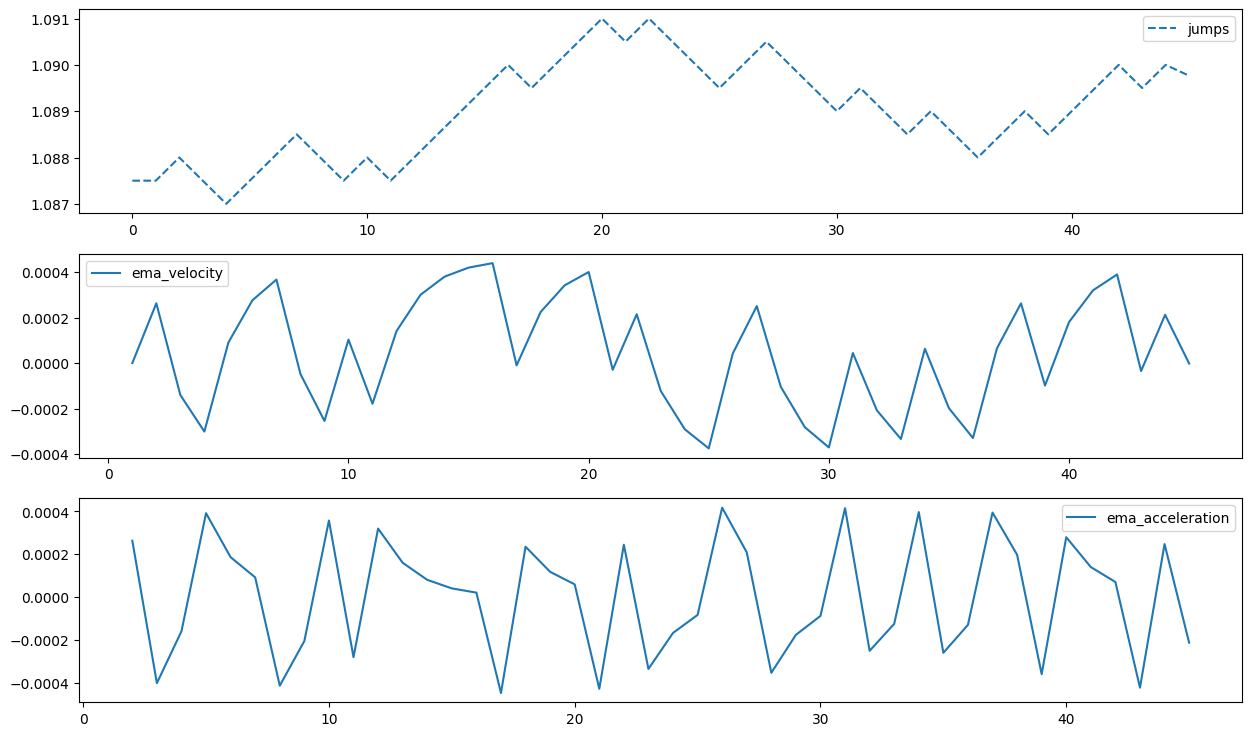

In [126]:
# Plot the results
fig,axs = plt.subplots(3,1,figsize=(15,9))
axs[0].plot(jumps.values, label='jumps', linestyle='--')
#axs[0].plot(ladderized_data, label='Ladderized Data',alpha=0.5)
axs[0].legend()
axs[1].plot(velocity(jump_ema).values, label='ema_velocity')
axs[1].legend()
axs[2].plot(acceleration(jump_ema).values, label='ema_acceleration')
axs[2].legend()
plt.show() 